# Captcha Prediction Model

In [1]:
import albumentations
import numpy as np
import pandas as pd
import os
import glob
import random
from pprint import pprint
from tqdm import tqdm

# PyTorch Model
import torch
from torch import nn
from torch.nn import functional as F

# Dataset Loading
from PIL import Image
from PIL import ImageFile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Model Training
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Configurations for the files
DIR = "../input/captcha-images/"
BATCH_SIZE = 8
IMG_HEIGHT = 75
IMG_WIDTH = 300
EPOCHS = 150
NUM_WORKERS = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


## Image Analysis

In [3]:
paths = []
labels = []
for image in os.listdir(DIR):
    paths.append(os.path.join(DIR, image))
    labels.append(image.split(".")[0])

df = pd.DataFrame({
    "paths": paths,
    "labels": labels
})

# In thông tin về tập huấn luyện
print("Data Set:")
print(df.head())


Data Set:
                                    paths      labels
0  ../input/captcha-images/9PNbWC13Ys.jpg  9PNbWC13Ys
1  ../input/captcha-images/8TVve827jK.jpg  8TVve827jK
2  ../input/captcha-images/OJ0YWLEie9.jpg  OJ0YWLEie9
3  ../input/captcha-images/w3ph8L0ulv.jpg  w3ph8L0ulv
4  ../input/captcha-images/9Ia9SnebKw.jpg  9Ia9SnebKw


In [4]:
def show_random_images(df, column_name):
    f = plt.figure(figsize=(10,10))
    i=1
    for i in range(16):
        i += 1
        ax = f.add_subplot(4,4,i)
        sample = random.choice(df[column_name])
        image = mpimg.imread(sample)
        ax.set_title(sample.split("/")[-1])
        plt.imshow(image)

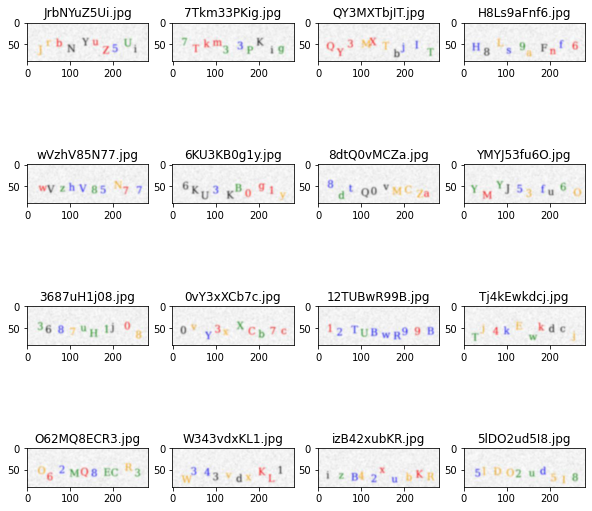

In [5]:
show_random_images(df, "paths")

## Model

In [6]:
def get_loss_function(x, bs, targets):
    log_softmax_values = F.log_softmax(x, 2)

    input_lengths = torch.full(
        size=(bs,), fill_value=log_softmax_values.size(0), dtype=torch.int32
    )

    target_lengths = torch.full(
        size=(bs,), fill_value=targets.size(1), dtype=torch.int32
    )

    return nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)

In [7]:
class MyCaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(MyCaptchaModel, self).__init__()
        
        # CNN Layer
        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        # RNN Layer Preprocess
        self.linear1 = nn.Linear(1152, 64)
        self.drop1 = nn.Dropout(0.2)
        
        # LSTM GRU
        self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, num_chars+1)
        
    def forward(self, images, targets=None):  
        bs, channel, height, width = images.size()
        
        x = F.relu(self.conv1(images))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)

        x = self.linear1(x)
        x = self.drop1(x)

        x, _ = self.gru(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if targets is not None:
            loss = get_loss_function(x, bs, targets)
            return x, loss
        
        return x, None

In [8]:
def train_function(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
        for k, v in data.items():
            data[k] = v.to(DEVICE)
        
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()

    return fin_loss / len(data_loader)

    
def eval_function(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad(): 
        tk = tqdm(data_loader, total=len(data_loader))
        for data in tk:
            for k, v in data.items():
                data[k] = v.to(DEVICE)

            batch_preds, loss = model(**data)
            fin_loss += loss.item()
            fin_preds.append(batch_preds)

    return fin_preds, fin_loss / len(data_loader)

## Parse Images & Encode Labels

In [9]:
def encode_targets():
  # Load images from files
  image_files = glob.glob(os.path.join(DIR, "*.jpg"))
  image_files_png = glob.glob(os.path.join(DIR, "*.png"))
  image_files.extend(image_files_png)
  targets_orig = [x.split("/")[-1].split(".")[0] for x in image_files]
  targets = [[c for c in x] for x in targets_orig]
  targets_flat = [c for clist in targets for c in clist] # squeeze

  # Encode images
  lbl_enc = LabelEncoder()
  lbl_enc.fit(targets_flat)

  targets_enc = [lbl_enc.transform(x) for x in targets]
  targets_enc = np.array(targets_enc) + 1 # transform to np and remove 0 index

  return image_files, targets_enc, targets_orig, lbl_enc

In [10]:
# Train-test split
image_files, targets_enc, targets_orig, lbl_enc = encode_targets()

(train_imgs, test_imgs, train_targets, test_targets, _, test_orig_targets) = train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.1, random_state=0)


## Dataset Classifier Class

In [11]:
ImageFile.LoadTruncatedImages = True

class DatasetClassifier:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.aug = albumentations.Compose(
            [
             albumentations.Normalize(always_apply=True)
            ]
            )
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        target = self.targets[item]
        
        if self.resize is not None:
            image = image.resize((self.resize[1], self.resize[0]), resample=Image.Resampling.BILINEAR)
        
        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(target, dtype=torch.long)
        }

In [12]:
# Classify images, load using pytorch's DataLoader
train_dataset = DatasetClassifier(
    image_paths=train_imgs, targets=train_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

test_dataset = DatasetClassifier(
    image_paths=test_imgs, targets=test_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

## Create Model, Optimizers, Callbacks

In [13]:
# Load the models
model = MyCaptchaModel(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

# Create optimizer and callbacks
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)

In [14]:
def early_stopping(patience, count, prev_loss, current_loss, threshold):
    if abs(prev_loss - current_loss) < threshold and count >= patience:
        return "stop" 
    elif abs(prev_loss - current_loss) < threshold:
        return "count"
    else:
        return False

## Decoding the Predictions

In [15]:
def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j,:]:
            k = k - 1
            if k == -1:
                temp.append("-")
            else:
                temp.append(encoder.inverse_transform([k])[0])
        tp = "".join(temp)
        cap_preds.append(tp)
    return cap_preds

## Running the training model

In [16]:
patience = 6
count = 0
prev_train_loss = 0
threshold = 0.05
loss = []

for epoch in range(EPOCHS):
    train_loss = train_function(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_function(model, test_loader)
    valid_cap_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_cap_preds.extend(current_preds)
        
    pprint(list(zip(test_orig_targets, valid_cap_preds))[15:20])
    print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
    
    res = early_stopping(patience, count, prev_train_loss, train_loss, threshold)
    
    loss.append(train_loss)
    
    if res == "stop":
        print("Early Stopping Implemented.")
        final_epoch = epoch
        break
    elif res == "count" and train_loss < 0.2:
        count += 1
        print(f"Patience at {patience-count}")
    else:
        prev_train_loss = train_loss

100%|██████████| 125/125 [00:02<00:00, 47.37it/s]


[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 0, train_loss: 4.61500627983941, valid_loss: 4.247027965545654


100%|██████████| 125/125 [00:01<00:00, 72.81it/s]


[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 1, train_loss: 4.239487129635281, valid_loss: 4.2439805603027345


100%|██████████| 125/125 [00:01<00:00, 74.12it/s]


[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 2, train_loss: 4.2387698025173615, valid_loss: 4.243046531677246


100%|██████████| 125/125 [00:01<00:00, 74.77it/s]


[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 3, train_loss: 4.235507503933377, valid_loss: 4.232561824798584


100%|██████████| 125/125 [00:01<00:00, 74.30it/s]


[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 4, train_loss: 4.22407556491428, valid_loss: 4.212572784423828


100%|██████████| 125/125 [00:01<00:00, 73.17it/s]


[('FP8D31PB8O',
  '1111-11--------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '1111111--------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '11111----------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '1111111--------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '11111----------------------------------------------------------------------')]
Epoch: 5, train_loss: 4.199830340491401, valid_loss: 4.189044202804565


100%|██████████| 125/125 [00:01<00:00, 74.73it/s]


[('FP8D31PB8O',
  '1----111-------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '1----111-------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '1--11----------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '1----111-------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '1--11--1-------------------------------------------------------------------')]
Epoch: 6, train_loss: 4.178801672193739, valid_loss: 4.177609924316406


100%|██████████| 125/125 [00:01<00:00, 74.72it/s]


[('FP8D31PB8O',
  '666666966------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '666666666------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '666666666------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '666666666------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '666666666------------------------------------------------------------------')]
Epoch: 7, train_loss: 4.172906639311049, valid_loss: 4.1741483116149904


100%|██████████| 125/125 [00:01<00:00, 73.59it/s]


[('FP8D31PB8O',
  '800000999------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '800003377------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '800000009------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '800000937------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '800000099------------------------------------------------------------------')]
Epoch: 8, train_loss: 4.169252741283841, valid_loss: 4.17360120010376


100%|██████████| 125/125 [00:01<00:00, 69.90it/s]


[('FP8D31PB8O',
  '3333-33336-----------------------------------------------------------------'),
 ('y6V9drq2FD',
  '333333333------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '333333333------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '3333333336-----------------------------------------------------------------'),
 ('Il40rp4HT2',
  '3333333336-----------------------------------------------------------------')]
Epoch: 9, train_loss: 4.164820046954685, valid_loss: 4.166189561843872


100%|██████████| 125/125 [00:01<00:00, 74.95it/s]


[('FP8D31PB8O',
  '9900000006-----------------------------------------------------------------'),
 ('y6V9drq2FD',
  '999000099------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '9000000112-----------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '9999222299-----------------------------------------------------------------'),
 ('Il40rp4HT2',
  '7772222236-----------------------------------------------------------------')]
Epoch: 10, train_loss: 4.128072156058417, valid_loss: 4.111207431793213


100%|██████████| 125/125 [00:01<00:00, 74.72it/s]


[('FP8D31PB8O',
  '7772-99966-----------------------------------------------------------------'),
 ('y6V9drq2FD',
  '9999661111-----------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '9999012227-----------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '7722-26666-----------------------------------------------------------------'),
 ('Il40rp4HT2',
  '7777221666-----------------------------------------------------------------')]
Epoch: 11, train_loss: 4.089016476525201, valid_loss: 4.0786113300323485


100%|██████████| 125/125 [00:01<00:00, 74.07it/s]


[('FP8D31PB8O',
  '8400999999-----------------------------------------------------------------'),
 ('y6V9drq2FD',
  '0000009666-----------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '0000001222-----------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '244-990000-----------------------------------------------------------------'),
 ('Il40rp4HT2',
  '7777-44406-----------------------------------------------------------------')]
Epoch: 12, train_loss: 4.052278485404121, valid_loss: 4.035927864074707


100%|██████████| 125/125 [00:01<00:00, 75.03it/s]


[('FP8D31PB8O',
  '0000--0000-----------------------------------------------------------------'),
 ('y6V9drq2FD',
  '3000002222-----------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '800000-222-----------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '12-0000000-----------------------------------------------------------------'),
 ('Il40rp4HT2',
  '777----011-----------------------------------------------------------------')]
Epoch: 13, train_loss: 4.014982445822822, valid_loss: 3.992073606491089


100%|██████████| 125/125 [00:01<00:00, 74.41it/s]


[('FP8D31PB8O',
  '800022-999-----------------------------------------------------------------'),
 ('y6V9drq2FD',
  '3400002255-----------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '8400002751-----------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '8240099990-----------------------------------------------------------------'),
 ('Il40rp4HT2',
  '277-996665-----------------------------------------------------------------')]
Epoch: 14, train_loss: 3.972867071363661, valid_loss: 3.943867073059082


100%|██████████| 125/125 [00:01<00:00, 75.09it/s]


[('FP8D31PB8O',
  '8001--9999-----------------------------------------------------------------'),
 ('y6V9drq2FD',
  '80000-2221-----------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '810000-211-----------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '82-09M9996-----------------------------------------------------------------'),
 ('Il40rp4HT2',
  '12---9--15-----------------------------------------------------------------')]
Epoch: 15, train_loss: 3.92952415339152, valid_loss: 3.9020796222686767


100%|██████████| 125/125 [00:01<00:00, 71.46it/s]


[('FP8D31PB8O',
  '1000---990-----------------------------------------------------------------'),
 ('y6V9drq2FD',
  '800000--52-----------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '81-000--14-----------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '62-00-9990-----------------------------------------------------------------'),
 ('Il40rp4HT2',
  '33------41-----------------------------------------------------------------')]
Epoch: 16, train_loss: 3.8887905883789062, valid_loss: 3.859432506561279


 95%|█████████▌| 1072/1125 [00:27<00:01, 40.07it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 125/125 [00:01<00:00, 73.43it/s]


[('FP8D31PB8O',
  'FP-------8------------D-------3----1-----P---------B----88----O------------'),
 ('y6V9drq2FD',
  'y6-------V-------------99---d-------r------q----2------F-------D-----------'),
 ('VIQpVKs9cA',
  'Vf-------Q---------------p---V-------K------s--9--------c------A-----------'),
 ('Vc0XVdk8Rl',
  'Vc-------0------------XX-----------d-------k-----8------R-----l------------'),
 ('Il40rp4HT2',
  'Il-------4-------------0------r-----p-------4----H-------T----2------------')]
Epoch: 35, train_loss: 0.38973641807503173, valid_loss: 0.28550550282001497


100%|██████████| 125/125 [00:01<00:00, 71.51it/s]


[('FP8D31PB8O',
  'FP-------8------------D-------3----1-----P---------B----8-----O------------'),
 ('y6V9drq2FD',
  'y6-------V-------------99---d-------r------q----2------F-------D-----------'),
 ('VIQpVKs9cA',
  'Vf-------Q---------------p---V-------K------s--9--------c------A-----------'),
 ('Vc0XVdk8Rl',
  'VL-------0------------XX------K----d-------k-----8------R-----l------------'),
 ('Il40rp4HT2',
  'Ij-------4-------------0------r-----p-------4----H-------T----2------------')]
Epoch: 36, train_loss: 0.3561446732282639, valid_loss: 0.2594119416475296


100%|██████████| 125/125 [00:01<00:00, 75.28it/s]


[('FP8D31PB8O',
  'FP------8-------------D-------3----1-----P---------B-----8----f------------'),
 ('y6V9drq2FD',
  'y6------V--------------99---d-------r------q----2------F-------D-----------'),
 ('VIQpVKs9cA',
  'Vf------Q----------------p---VV------KK-----s--9--------c------A-----------'),
 ('Vc0XVdk8Rl',
  'Vc------0--------------X-------V---d-------k-----88-----R-----l------------'),
 ('Il40rp4HT2',
  'Il------4--------------0------r-----p-------4----H-------T----2------------')]
Epoch: 37, train_loss: 0.33600861042075686, valid_loss: 0.24873574870824813


100%|██████████| 125/125 [00:01<00:00, 75.18it/s]


[('FP8D31PB8O',
  'FP------8-------------D-------3----1-----P---------B-----8----f------------'),
 ('y6V9drq2FD',
  'y6------V---------------9---d-------r------q----2------F-------D-----------'),
 ('VIQpVKs9cA',
  'VJ------Q----------------p----V------KK-----s--9--------c------A-----------'),
 ('Vc0XVdk8Rl',
  'Vc------0--------------X-------V---d-------k-----88-----R-----l------------'),
 ('Il40rp4HT2',
  'Il------4--------------0------r-----p-------4----H-------T----2------------')]
Epoch: 38, train_loss: 0.3083039279248979, valid_loss: 0.21789263433218004


100%|██████████| 125/125 [00:01<00:00, 74.97it/s]


[('FP8D31PB8O',
  'FP------8-------------D-------3----1-----P---------B----8-----O------------'),
 ('y6V9drq2FD',
  'y6------V--------------99---d-------r------q----2------F-------D-----------'),
 ('VIQpVKs9cA',
  'VJ------Q----------------p---VV------K------s--9--------c------A-----------'),
 ('Vc0XVdk8Rl',
  'Vc------0--------------X-------V---d-------k-----8------R-----l------------'),
 ('Il40rp4HT2',
  'Il------4--------------0------r-----p-------4----H-------T----2------------')]
Epoch: 39, train_loss: 0.285190694378482, valid_loss: 0.20482857185602188


100%|██████████| 125/125 [00:01<00:00, 72.72it/s]


[('FP8D31PB8O',
  'FP------8-------------D-------3---11-----P---------B----88----O------------'),
 ('y6V9drq2FD',
  'y6------V--------------99---d-------r------q----2------F-------D-----------'),
 ('VIQpVKs9cA',
  'VJ------Q----------------p---V-------K-----ss--9--------c------A-----------'),
 ('Vc0XVdk8Rl',
  'Vc------0-------------XX------V----d-------k-----8------R-----l------------'),
 ('Il40rp4HT2',
  'Il------4--------------0------r-----p-------4----H-------T----2------------')]
Epoch: 40, train_loss: 0.2653073929415809, valid_loss: 0.18711223149299622


100%|██████████| 125/125 [00:01<00:00, 75.09it/s]


[('FP8D31PB8O',
  'FP------8-------------D-------3---11-----P---------B-----8----f------------'),
 ('y6V9drq2FD',
  'y6------V---------------9---d-------r------q----2------F-------D-----------'),
 ('VIQpVKs9cA',
  'VJ------Q----------------p----V------KK-----s--9--------c------A-----------'),
 ('Vc0XVdk8Rl',
  'Vc------0--------------X-------V---d-------k-----88-----R-----l------------'),
 ('Il40rp4HT2',
  'Il------4--------------0------r-----p-------4----H-------T----2------------')]
Epoch: 41, train_loss: 0.24563637846708297, valid_loss: 0.16872345757484436


100%|██████████| 125/125 [00:01<00:00, 75.70it/s]


[('FP8D31PB8O',
  'FP------8-------------D-------3----1-----P---------B-----8----f------------'),
 ('y6V9drq2FD',
  'y6------V---------------9---d-------r------q----2------F-------D-----------'),
 ('VIQpVKs9cA',
  'VJ------Q----------------p----V------KK-----s--9--------c------A-----------'),
 ('Vc0XVdk8Rl',
  'Vc------0--------------X------V----d-------k-----88-----R-----l------------'),
 ('Il40rp4HT2',
  'Il------4--------------0------r-----p-------4----H-------T----2------------')]
Epoch: 42, train_loss: 0.23212870375315348, valid_loss: 0.16239920097589494


100%|██████████| 125/125 [00:01<00:00, 75.21it/s]


[('FP8D31PB8O',
  'FP------8-------------D-------3---11-----P---------B----88----O------------'),
 ('y6V9drq2FD',
  'y6------V--------------99---d-------r------q----2------F-------D-----------'),
 ('VIQpVKs9cA',
  'VJ------Q----------------p---VV------K------s--9--------c------A-----------'),
 ('Vc0XVdk8Rl',
  'Vc------0-------------X-------V----d-------k-----88-----R-----l------------'),
 ('Il40rp4HT2',
  'Il------4--------------0------r-----p-------4----H-------T----2------------')]
Epoch: 43, train_loss: 0.21427126809623506, valid_loss: 0.14639906948804857


100%|██████████| 125/125 [00:01<00:00, 74.61it/s]


[('FP8D31PB8O',
  'FP-------8------------D-------3----1-----P---------B----88----O------------'),
 ('y6V9drq2FD',
  'y6-------V--------------9---d-------r------q----2-------F------D-----------'),
 ('VIQpVKs9cA',
  'VJ-------Q---------------p----V------KK-----s--9--------c------A-----------'),
 ('Vc0XVdk8Rl',
  'Vc-------0-------------X-------V---d-------k------8-----R-----l------------'),
 ('Il40rp4HT2',
  'Il-------4-------------0------r-----p-------4----H-------T----2------------')]
Epoch: 44, train_loss: 0.20468158851729498, valid_loss: 0.13317360094189643


100%|██████████| 125/125 [00:01<00:00, 75.43it/s]


[('FP8D31PB8O',
  'FP-------8------------D-------3----1-----P---------B----88----f------------'),
 ('y6V9drq2FD',
  'y6-------V--------------9---d-------r------q----2------FF------D-----------'),
 ('VIQpVKs9cA',
  'VJ-------Q---------------p----V------KK-----s--9--------c------A-----------'),
 ('Vc0XVdk8Rl',
  'Vc-------0-------------X-------V---d-------k-----88-----R-----l------------'),
 ('Il40rp4HT2',
  'Il-------4-------------0------r-----p-------4----H-------T----2------------')]
Epoch: 45, train_loss: 0.1908123593793975, valid_loss: 0.1305552316904068
Patience at 5


 50%|████▉     | 561/1125 [00:14<00:14, 39.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
torch.save(model.state_dict(), "./model.bin")

## Model Performance

<AxesSubplot:title={'center':'Loss During Epoch Training'}, xlabel='Epoch No.', ylabel='Loss Value'>

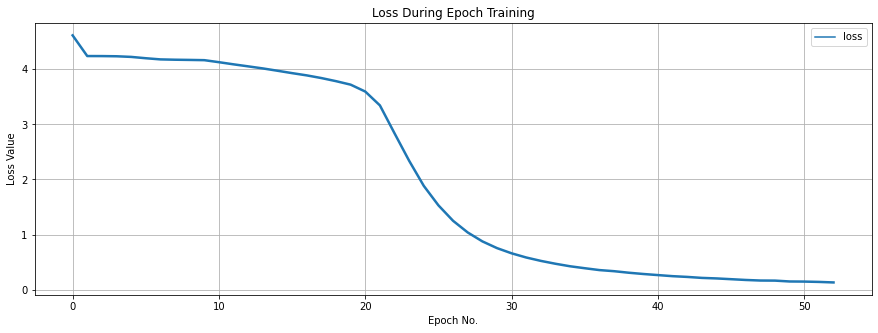

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pytorch = pd.DataFrame({"loss": loss})
plt.figure(figsize=(15,5))
plt.grid()
plt.xlabel("Epoch No.")
plt.ylabel("Loss Value")
plt.title("Loss During Epoch Training")
sns.lineplot(data=df_pytorch, palette="tab10", linewidth=2.5)

## Serving Predictions

In [19]:
def get_image(image_path=None):
    if image_path == None:
        img = random.choice(df["paths"])
        return [img]
    return [image_path]


def get_sample_photo(image_path=None):
    img = get_image(image_path)
    eval_dataset = DatasetClassifier(
        image_paths=img, targets=[np.array([x for x in np.arange(10)])], resize=(IMG_HEIGHT, IMG_WIDTH)
    )

    eval_loader = torch.utils.data.DataLoader(
        eval_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=False
    )
    return img, eval_loader


def predict_function(model, data_loader):
    model.eval()
    fin_preds = []
    with torch.no_grad(): 
        for data in data_loader:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, _ = model(**data)
            fin_preds.append(batch_preds)

    return fin_preds

In [20]:
def clean_decoded_predictions(unclean_predictions):
    cleaned_predictions = []
    for i in unclean_predictions:
        if i != "-":
            cleaned_predictions.append(i)
            
    cleaned_predictions = "".join(cleaned_predictions)
    
    if len(cleaned_predictions) == 10:
        return cleaned_predictions   
    
    else:
        prev = "-"
        new_cleaned_predictions = []
        for char in cleaned_predictions:
            if char == prev:
                continue
            new_cleaned_predictions.append(char)
            prev = char
        res = "".join(new_cleaned_predictions)
        return res
    
def predict_captcha(model, eval_loader, image_path):
    plt.figure(figsize=(15,5))
    image = mpimg.imread(image_path[0])
    target = image_path[0].split("/")[-1].split(".")[0]
    plt.title(image_path[0].split("/")[-1])
    plt.imshow(image)
    
    valid_preds = predict_function(model, eval_loader)
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
    
    preds = clean_decoded_predictions(current_preds[0])
    
    success = True if preds == target else False

    return{
        "success": success,
        "prediction": preds,
        "real": target
    }

['../input/captcha-images/17979W5gV6.jpg']


['../input/captcha-images/OS83hNgb1h.jpg']


{'success': True, 'prediction': 'OS83hNgb1h', 'real': 'OS83hNgb1h'}

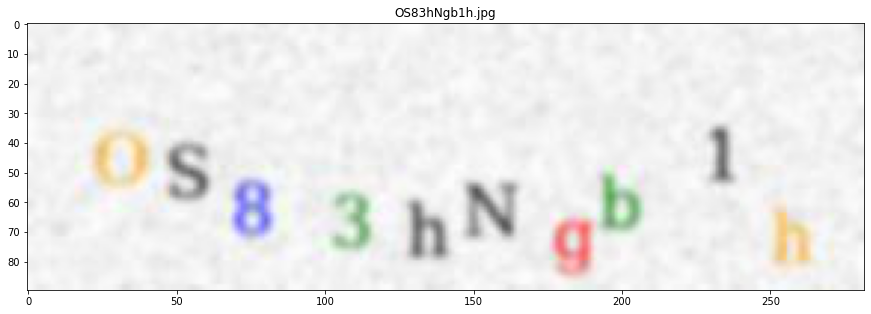

In [38]:
image_path, eval_loader = get_sample_photo()
print(image_path)
preds = predict_captcha(model, eval_loader, image_path)
preds

{'success': True, 'prediction': 'UhdP6Yr450', 'real': 'UhdP6Yr450'}
{'success': True, 'prediction': '2nwfiDQ343', 'real': '2nwfiDQ343'}
{'success': False, 'prediction': 'JPEART16G6', 'real': 'JbEART16G6'}
{'success': True, 'prediction': 'MLuqK5R9Oh', 'real': 'MLuqK5R9Oh'}
{'success': True, 'prediction': '3UAb8953H7', 'real': '3UAb8953H7'}


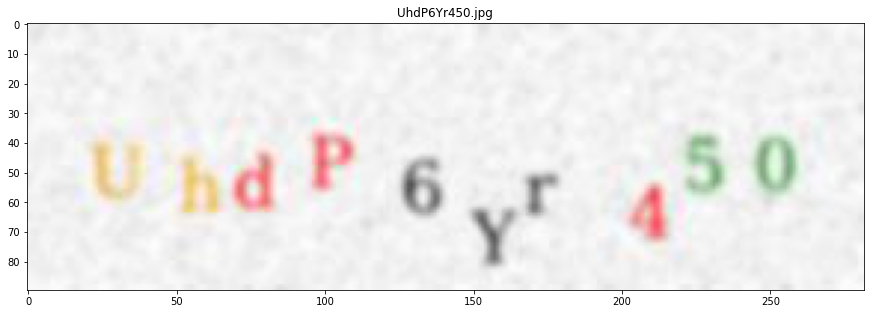

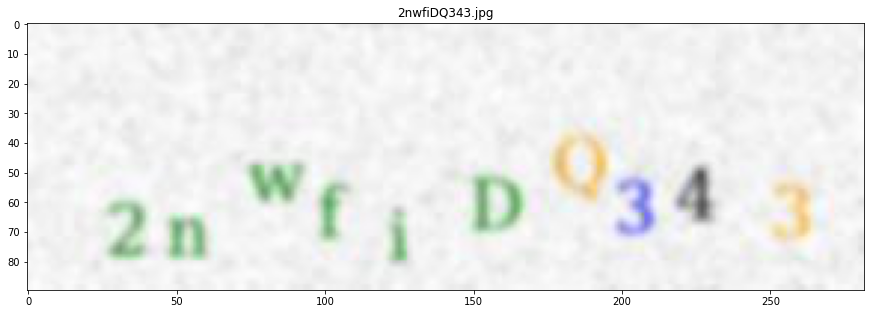

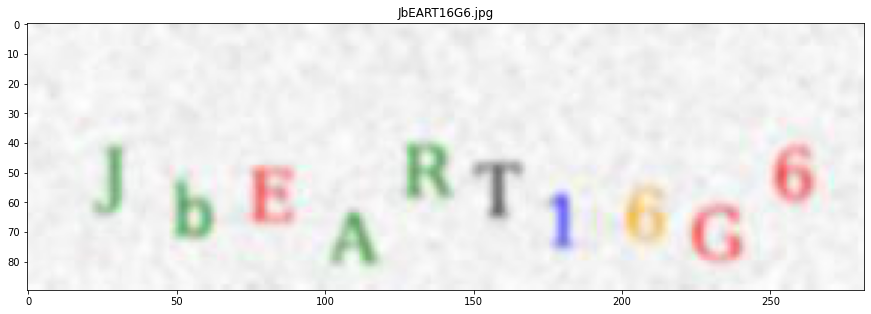

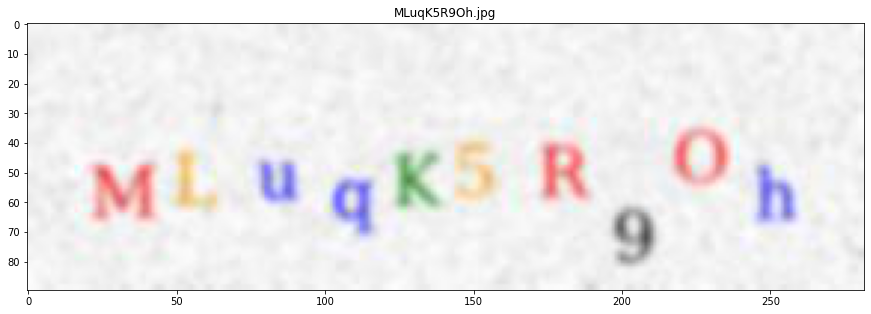

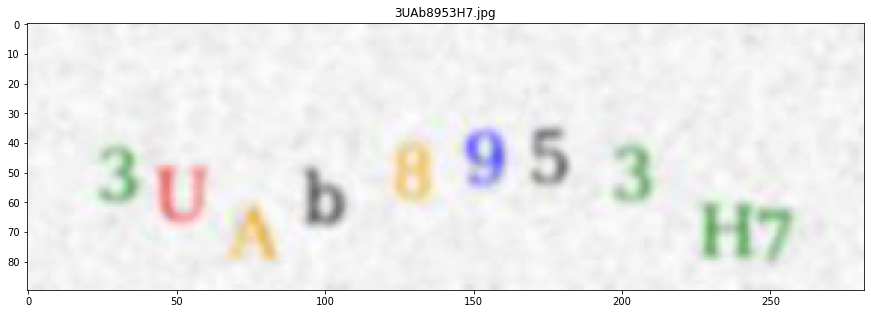

In [35]:
for i in range(5):
    image_path, eval_loader = get_sample_photo()
    preds = predict_captcha(model, eval_loader, image_path)
    print(preds)

In [22]:
def predict(model, eval_loader, image_path):
    image = mpimg.imread(image_path[0])
    target = image_path[0].split("/")[-1].split(".")[0]
    
    valid_preds = predict_function(model, eval_loader)
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
    
    preds = clean_decoded_predictions(current_preds[0])
    
    success = True if preds == target else False

    return{
        "success": success,
        "prediction": preds,
        "real": target
    }

## Sample Predictions

In [23]:
predict_ = []
for i in range(1000):
    image_path, eval_loader = get_sample_photo()
    preds = predict(model, eval_loader, image_path)
    predict_.append(preds)

In [25]:
!pip install jiwer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 11.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Uninstalling click-8.0.4:
      Successfully uninstalled click-8.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
spacy 3.3.1 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.3.0 which is incompatible.
ray 2.0.0 requires click<=8.0.4,>=7.0, but you have click 8.1.7 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.
allennlp 2.10.0 r

In [29]:
from jiwer import wer, cer

# Assuming `predict` is a list of dictionaries containing prediction information
# Each dictionary should have keys "success", "prediction", and "real"

# Extract predictions and ground truth from the list
predictions = [pred["prediction"] for pred in predict_]
ground_truth = [pred["real"] for pred in predict_]

# Calculate CER and WER
cer_result = cer(ground_truth, predictions)
wer_result = wer(ground_truth, predictions)

print("Character Error Rate (CER): {:.2%}".format(cer_result))
print("Word Error Rate (WER): {:.2%}".format(wer_result))

Character Error Rate (CER): 1.74%
Word Error Rate (WER): 15.60%
